# Assignment 2 Group 15 Data Visualization<br>
## Index
1. Import Requirements
2. Collect data from Elastic Search
3. Data Preprocessing
4. Income data introduction
5. Traffic accident data introduction
6. Correlation between income and traffic accidents
7. Correlation between weather (rainfall) and income
8. Correlation between weather (wind speed) and income
9. Correlation between weather (rainfall) and traffic accidents
10. Correlation between income and traffic accidents and weather

## 1. Import requirements

In [143]:
# Import requirements

from elasticsearch import Elasticsearch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import griddata
from elasticsearch import helpers

## 2. Collect data from Elastic Search

In [144]:
# Collect data from ElasticSearch

ELASTIC_SEARCH_SERVER= "https://localhost:9200"
es = Elasticsearch(ELASTIC_SEARCH_SERVER, basic_auth=("elastic", "elastic"), verify_certs=False)

# Test the elastic cluster health
try:
    health = es.cluster.health()
    print("Cluster health:", health)
except Exception as e:
    print(f"Error connecting to Elasticsearch: {e}")

# Indexs of data
weather_index = "weather-data1"
traffic_index_2023 = "traffic-2023"
income_index = "all_states_income-data"

index_list = [weather_index, traffic_index_2023, income_index] 

# Create empty lists for weather, income, and traffic data
weather_data = []
income_data = []
traffic_2023_data = []

for ind in index_list:
    # Initialize the scroll
    response = es.search(
        index=ind,
        body={
            'query': {
                'match_all': {}
            }
        },
        scroll='2m',  # Scroll context time
        size=10000    # Number of documents per batch
    )
    
    # Get the scroll ID
    scroll_id = response['_scroll_id']
    scroll_size = len(response['hits']['hits'])
    
    # Keep fetching data until the scroll is done
    while scroll_size > 0:
        # Append the current batch of hits to the corresponding list
        if ind == weather_index:
            weather_data.extend([hit['_source'] for hit in response['hits']['hits']])
        elif ind == income_index:
            income_data.extend([hit['_source'] for hit in response['hits']['hits']])
        elif ind == traffic_index_2023:
            traffic_2023_data.extend([hit['_source'] for hit in response['hits']['hits']])
        
        # Fetch the next batch of data
        response = es.scroll(
            scroll_id=scroll_id,
            scroll='2m'
        )
        
        # Update the scroll ID
        scroll_id = response['_scroll_id']
        # Get the number of results that were returned in the last scroll
        scroll_size = len(response['hits']['hits'])

# Convert the lists to dataframes
weather_df = pd.DataFrame(weather_data)
income_df = pd.DataFrame(income_data)
traffic_2023_df = pd.DataFrame(traffic_2023_data)  


/Users/YangWei-Chiao/Library/Python/3.9/lib/python/site-packages/elasticsearch/_sync/client/__init__.py:399: SecurityWarning: Connecting to 'https://localhost:9200' using TLS with verify_certs=False is insecure
  _transport = transport_class(
/Users/YangWei-Chiao/Library/Python/3.9/lib/python/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/var/folders/5r/n3pqt1ms4_s2z6g4dgvp22bc0000gn/T/ipykernel_2897/3737305812.py:27: DeprecationWarning: Received 'size' via a specific parameter in the presence of a 'body' parameter, which is deprecated and will be removed in a future version. Instead, use only 'body' or only specific parameters.
  response = es.search(
/Users/YangWei-Chiao/Library/Python/3.9/lib/python/site-packages/urllib3/connectionpool.py:1103: InsecureR

Cluster health: {'cluster_name': 'elasticsearch', 'status': 'green', 'timed_out': False, 'number_of_nodes': 2, 'number_of_data_nodes': 2, 'active_primary_shards': 41, 'active_shards': 82, 'relocating_shards': 0, 'initializing_shards': 0, 'unassigned_shards': 0, 'delayed_unassigned_shards': 0, 'number_of_pending_tasks': 0, 'number_of_in_flight_fetch': 0, 'task_max_waiting_in_queue_millis': 0, 'active_shards_percent_as_number': 100.0}


/Users/YangWei-Chiao/Library/Python/3.9/lib/python/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/YangWei-Chiao/Library/Python/3.9/lib/python/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/YangWei-Chiao/Library/Python/3.9/lib/python/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/Yan

## 3. Data Preprocessing

In [146]:
# Data Preprocessing
weather_df = weather_df.rename(columns={'station_name': 'suburb'})
income_df  = income_df.rename(columns={'lga_name':'suburb'})

# Conver the id to states
def change_id_to_state(id):
    state = ""
    try:
        if id == "IDN60801":
            state = "NSW"
        elif id == "IDV60801":
            state = "Vic"
        elif id == "IDQ60801":
            state = "Qld"
        elif id == "IDS60801":
            state = "SA"
        elif id == "IDW60801":
            state = "WA"
        elif id == "IDD60801":
            state = "NT" 
    except:
        state = "Other"
    return state

# convert income lga_code to state
income_df['State'] = income_df['lga_code'].apply(lambda x: 'NSW' if str(x).startswith('1') 
                                                 else ('Vic' if str(x).startswith('2') 
                                                 else ('Qld' if str(x).startswith('3') 
                                                 else ('SA' if str(x).startswith('4') 
                                                 else ('WA' if str(x).startswith('5') 
                                                 else ('Tas' if str(x).startswith('6') 
                                                 else ('NT' if str(x).startswith('7') 
                                                 else 'Other')))))))
income_state = income_df['State']
# Create a 'State' column based on the 'history_product'
weather_df['State'] = weather_df['history_product'].apply(change_id_to_state)

def extract_month(timestamp):
    # The month is represented by the 5th and 6th characters in the timestamp string
    month = int(timestamp[4:6])
    return str(month)

# Create a 'Month' column based on the 'timestamp'
weather_df['Month'] = weather_df['timestamp'].apply(extract_month)

# Merge weather and income by station
merged_df_station = pd.merge(weather_df, income_df, on='suburb', how='inner')
unique_values_suburb = merged_df_station['suburb'].unique()

# Merge weather and traffic_2023_df by State
merged_df_state = pd.merge(weather_df, traffic_2023_df, on='State')
unique_values = merged_df_state['State'].unique()
merged_df_suburb_income = pd.merge(weather_df, income_df, on='suburb')
unique_values_income = merged_df_suburb_income['suburb'].unique()

# Merge weather with income by suburb
merged_df_suburb_income = pd.merge(weather_df, income_df, on='suburb')
unique_values_income = merged_df_suburb_income['suburb'].unique()

## 4. Income data introduction

Median income for NSW: 44529.0
Median income for Vic: 43223.0
Median income for Qld: 42101.0
Median income for SA: 44027.0
Median income for WA: 48650.0
Median income for Tas: 42073.0
Median income for NT: 48834.5
Median income for Other: 55647.0


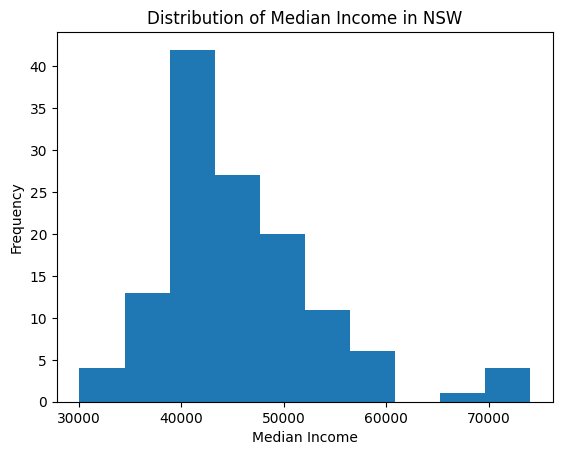

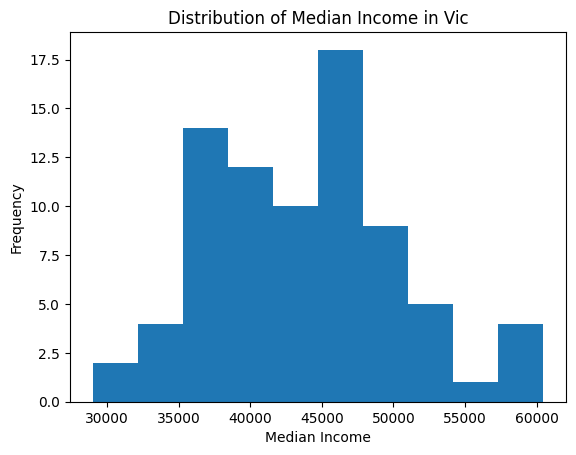

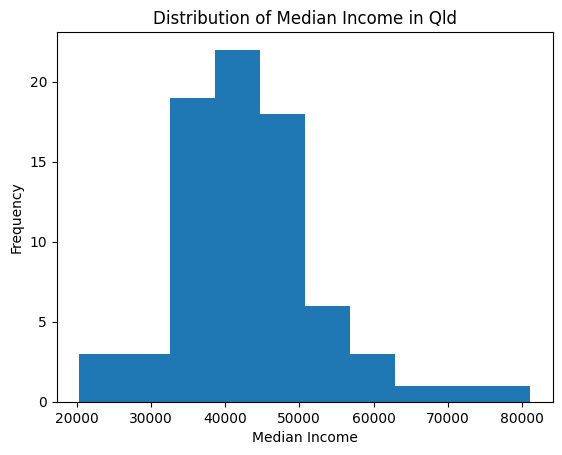

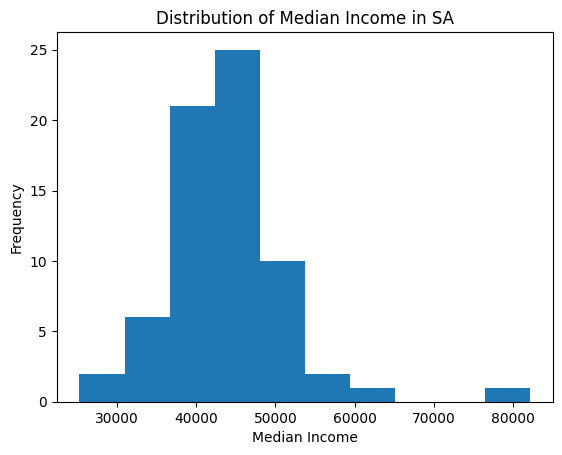

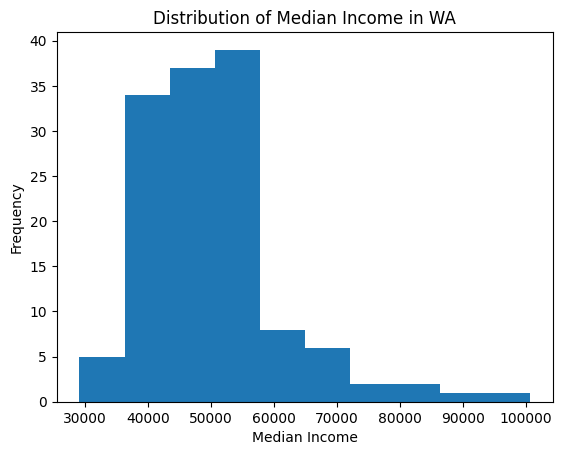

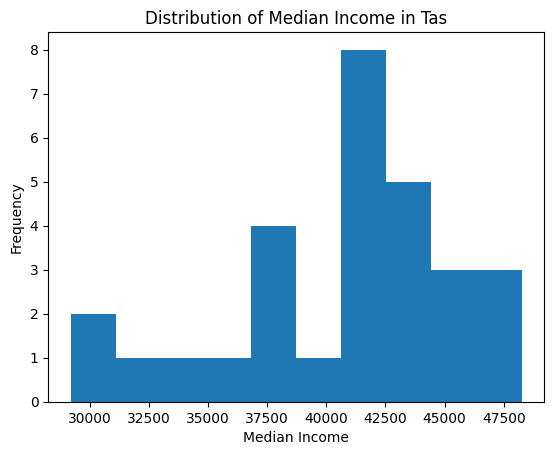

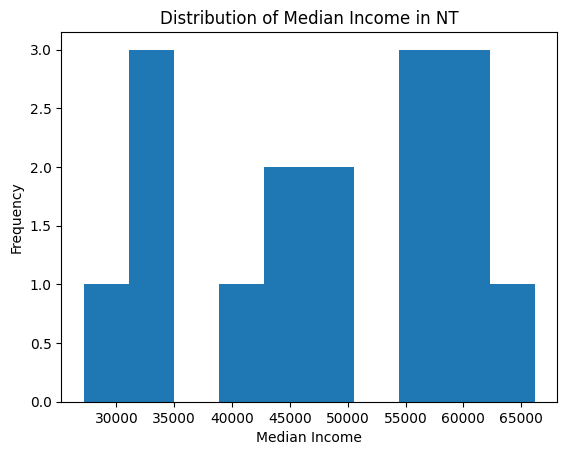

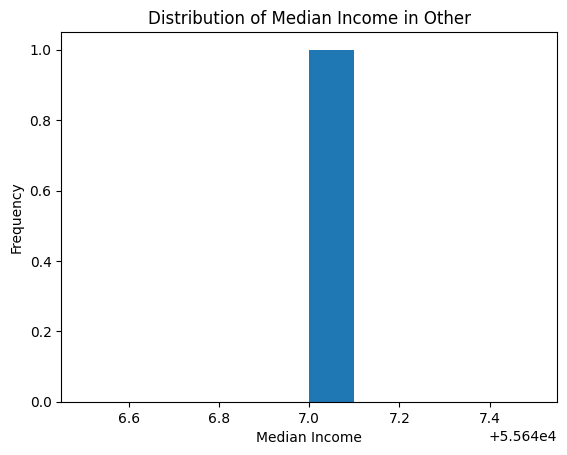

In [ ]:
# Income data Introduction

# Loop through each unique state
for state in income_df['State'].unique():

    #Calculate the median income for the current state
    median_income = income_df[income_df['State'].str.upper() == state.upper()]['median_aud'].median()
    print(f"Median income for {state}: {median_income}")

    # Create a new figure
    plt.figure()
    state_df = income_df[income_df['State'] == state]
    state_df['median_aud'].hist(grid=False)
    plt.title(f'Distribution of Median Income in {state}')
    plt.xlabel('Median Income')
    plt.ylabel('Frequency')
plt.show()


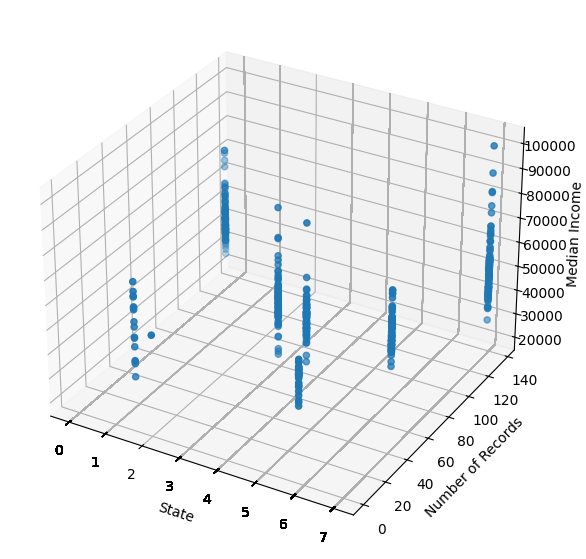

In [ ]:
# Calculate the frequency for each state
state_counts = income_df['State'].value_counts()

# Add a column for state counts to the income_df
income_df['Frequency'] = income_df['State'].apply(lambda x: state_counts[x])

# Convert 'State' to categorical codes
income_df['State'] = income_df['State'].astype('category').cat.codes

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the data
scatter = ax.scatter(income_df['State'], income_df['Frequency'], income_df['median_aud'])

ax.set_xlabel('State')
ax.set_ylabel('Number of Records')
ax.set_zlabel('Median Income')

# Set the x-tick labels to the 'State' strings
ax.set_xticks(income_df['State'])
ax.set_xticklabels(income_df['State'])
plt.show()

## 5. Traffic accident data introduction

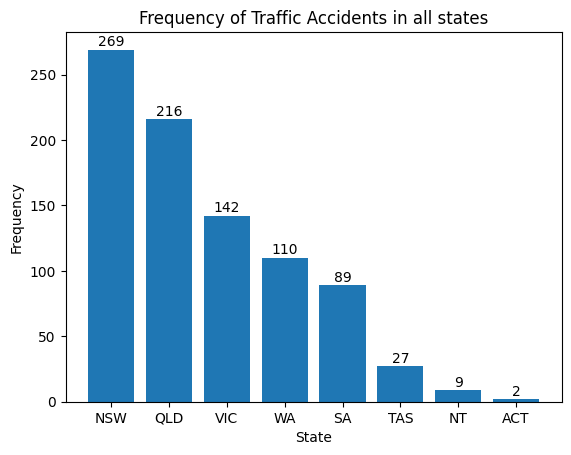

In [ ]:
# Traffic data introduction

# Capitalised the State
traffic_2023_df['State'] = traffic_2023_df['State'].str.upper()

# Get the frequency count of each state
state_counts = traffic_2023_df['State'].value_counts()

# Create a bar plot of the state counts
bars = plt.bar(state_counts.index, state_counts.values)

# Add the frequency count on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, yval, ha='center', va='bottom')
plt.title('Frequency of Traffic Accidents in all states')
plt.xlabel('State')
plt.ylabel('Frequency')

# Show the plot
plt.show()

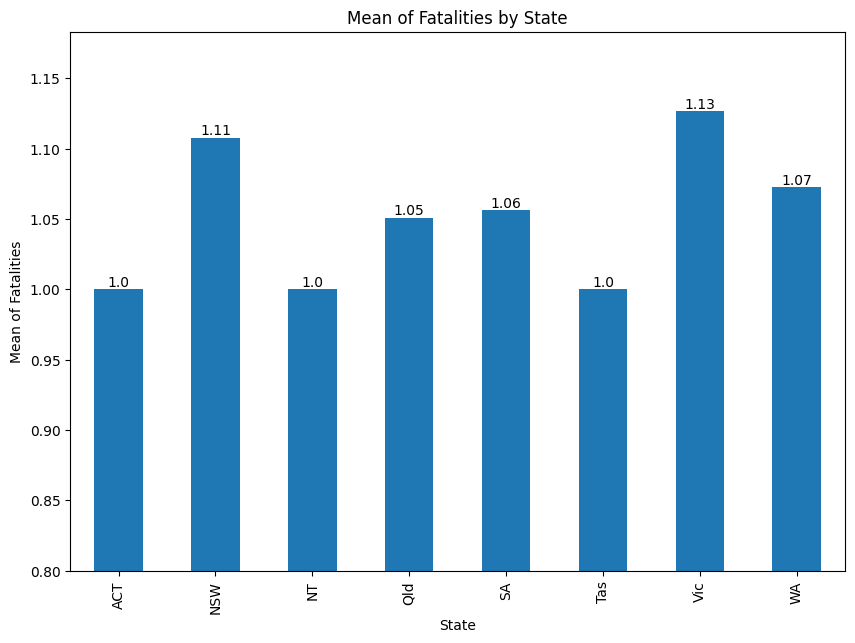

In [ ]:
# Distribution of Frequency of Fatalities by State
traffic_to_merge = pd.DataFrame(traffic_2023_data)  

# Change to numeric
traffic_to_merge['Number Fatalities']= pd.to_numeric(traffic_to_merge['Number Fatalities'], errors='coerce')
state_fatalities_mean = traffic_to_merge.groupby('State')['Number Fatalities'].mean()

# Create a bar plot
bars = state_fatalities_mean.plot(kind='bar', figsize=(10, 7))

for idx, value in enumerate(state_fatalities_mean):
    plt.text(idx, value, round(value, 2), ha='center', va='bottom')
    
plt.title('Mean of Fatalities by State')
plt.xlabel('State')
plt.ylabel('Mean of Fatalities')
plt.ylim(0.8, None)
plt.show()

## 6. Correlation between income and traffic accidents

0.0011154881182472995


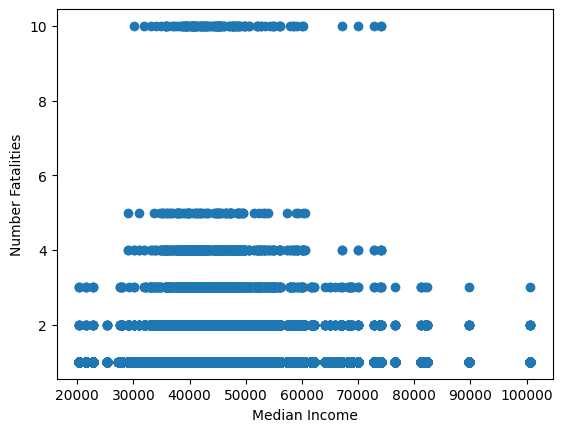

In [ ]:
# Correlation between income and traffic accidents
income_to_merge = pd.DataFrame(income_data)

# # Convert 'State' column to string in both DataFrames
traffic_to_merge['State'] = traffic_to_merge['State'].astype(str)
income_to_merge['State'] = income_state.astype(str)
merged_df = pd.merge(traffic_to_merge, income_to_merge, on='State')

# Convert the 'Number Fatalities' column to numeric
traffic_to_merge['Number Fatalities'] = pd.to_numeric(traffic_to_merge['Number Fatalities'], errors='coerce')
traffic_grouped = traffic_to_merge.groupby('State')['Number Fatalities'].sum()

traffic_state_counts = traffic_to_merge['State'].value_counts()

# Calculate the median of 'median_aud' for each state
income_grouped = income_df.groupby('State')['median_aud'].median()
merged_df = pd.merge(traffic_to_merge, income_to_merge, on='State')

# Calculate the correlation between 'Number Fatalities' and 'median_income'
correlation = merged_df['Number Fatalities'].corr(merged_df['median_aud'])

print(correlation)

plt.scatter(merged_df['median_aud'], merged_df['Number Fatalities'])
plt.xlabel('Median Income')
plt.ylabel('Number Fatalities')
plt.show()

## 7. Correlation between weather (rainfall) and income

/var/folders/5r/n3pqt1ms4_s2z6g4dgvp22bc0000gn/T/ipykernel_2897/271976382.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suburb_data['rainfall'] = pd.to_numeric(merged_df_station['rainfall'], errors='coerce')
/var/folders/5r/n3pqt1ms4_s2z6g4dgvp22bc0000gn/T/ipykernel_2897/271976382.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suburb_data['mean_aud'] = pd.to_numeric(merged_df_station['mean_aud'], errors='coerce')


Laverton average income : 76187.0 with average rainfall : 0.5944186046511628
Hunters Hill average income : 136108.0 with average rainfall : 0.0
Gladstone average income : 76985.0 with average rainfall : 0.0
Mount Isa average income : 77239.0 with average rainfall : 0.0
Karratha average income : 77036.0 with average rainfall : 0.0
Weipa average income : 88228.0 with average rainfall : 0.0
Esperance average income : 89475.0 with average rainfall : 0.053947368421052626
Northam average income : 137625.0 with average rainfall : 0.0
Wagin average income : 79583.0 with average rainfall : 0.0
Victor Harbor average income : 80068.0 with average rainfall : 1.4000000000000001
Pingelly average income : 84430.0 with average rainfall : 0.0
             suburb  mean_rainfall  mean_income
0          Laverton       0.594419      76187.0
1           Horsham       0.158744      45744.0
2             Cobar       0.000000      68050.0
3      Hunters Hill       0.000000     136108.0
4          Ballarat     

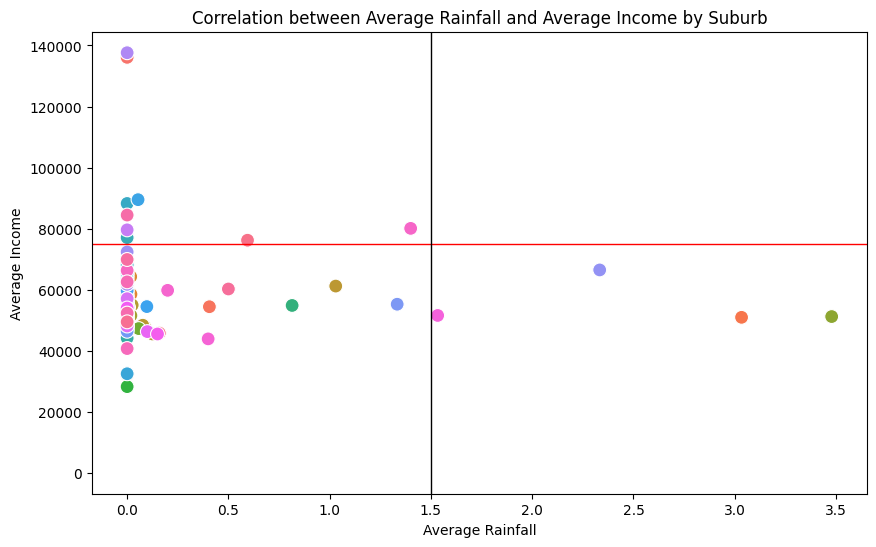

Correlation between Average Rainfall and Average Income: -0.016957974932558382


In [218]:
# Correlation between weather (rainfall) and income

mean_data_list = []

for suburb in unique_values_suburb:
    # Filter rows for the current suburb
    suburb_data = merged_df_station[merged_df_station['suburb'] == suburb]

    suburb_data['rainfall'] = pd.to_numeric(merged_df_station['rainfall'], errors='coerce')
    suburb_data['mean_aud'] = pd.to_numeric(merged_df_station['mean_aud'], errors='coerce')
    # Calculate mean values for 'rainfall' and 'income'
    mean_rainfall = (suburb_data['rainfall']).mean()
    mean_income = suburb_data['mean_aud'].mean()
    if mean_rainfall <= 1.5 and mean_income >= 75000:
        print(f"{suburb} average income : {mean_income} with average rainfall : {mean_rainfall}")
    if mean_rainfall == mean_rainfall:
        mean_data_list.append({'suburb': suburb, 'mean_rainfall': mean_rainfall, 'mean_income': mean_income})

# Convert the list to a data frame for plotting
mean_data_df = pd.DataFrame(mean_data_list)
print(mean_data_df)

# Remove outliers from the df
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# mean_data_df = remove_outliers(mean_data_df, 'mean_rainfall')
# mean_data_df = remove_outliers(mean_data_df, 'mean_income')

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean_rainfall', y='mean_income', hue='suburb', data=mean_data_df, s=100)
plt.title('Correlation between Average Rainfall and Average Income by Suburb')
plt.xlabel('Average Rainfall')
plt.ylabel('Average Income')
plt.axline((0,75000),(3,75000), linewidth=1, color="r")
plt.axline((1.5,0), (1.5,80000), linewidth=1, color="k")
plt.legend('',frameon=False)
#plt.legend(title='Suburb')
plt.show()

# Drop any rows with NaN values that could have arisen from the mean calculation
mean_data_df.dropna(inplace=True)

# Calculate the Pearson correlation coefficient
correlation = mean_data_df['mean_rainfall'].corr(mean_data_df['mean_income'])

print(f"Correlation between Average Rainfall and Average Income: {correlation}")

## 8. Correlation between weather (wind speed) and income

/var/folders/5r/n3pqt1ms4_s2z6g4dgvp22bc0000gn/T/ipykernel_2897/49838875.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suburb_data['wind_speed_kmh'] = pd.to_numeric(suburb_data['wind_speed_kmh'], errors='coerce')


Hunters Hill average income : 136108.0 with average wind speed : 4.385474860335195
Laverton average income : 76187.0 with average wind speed : 13.64186046511628
Gladstone average income : 76985.0 with average wind speed : 12.793333333333333
Mount Isa average income : 77239.0 with average wind speed : 20.033333333333335
Karratha average income : 77036.0 with average wind speed : 24.19333333333333
Weipa average income : 88228.0 with average wind speed : 17.52317880794702
Esperance average income : 89475.0 with average wind speed : 14.80921052631579
Northam average income : 137625.0 with average wind speed : 1.3333333333333333
Wagin average income : 79583.0 with average wind speed : 11.5
Victor Harbor average income : 80068.0 with average wind speed : 14.333333333333334
Pingelly average income : 84430.0 with average wind speed : 5.0


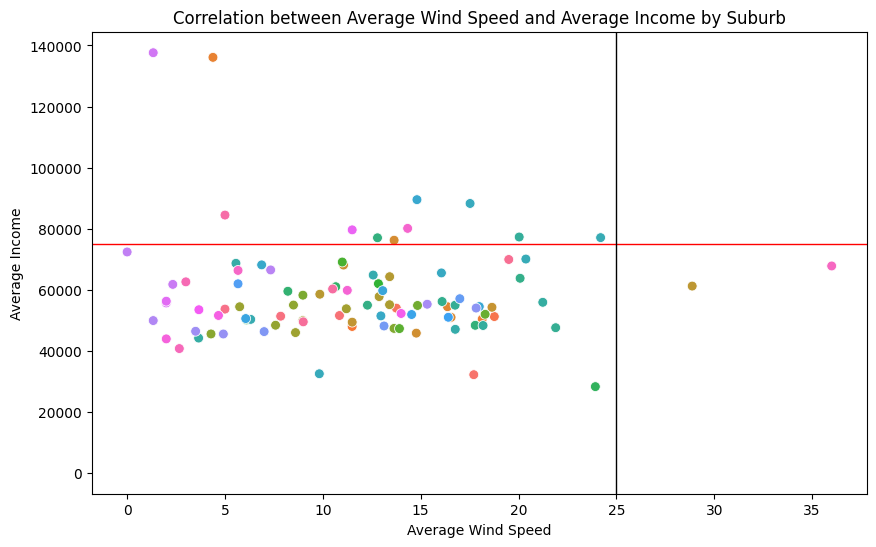

Correlation between Average Wind Speed and Average Income: -0.06789876717521477


In [ ]:
# Correlation between weather (wind speed) and income

mean_data_list = []

for suburb in unique_values_income:
    # Filter rows for the current suburb
    suburb_data = merged_df_suburb_income[merged_df_suburb_income['suburb'] == suburb]

    suburb_data['wind_speed_kmh'] = pd.to_numeric(suburb_data['wind_speed_kmh'], errors='coerce')
    
    # Calculate mean values for 'rainfall' and 'income'
    mean_wind_speed_kmh = (suburb_data['wind_speed_kmh']).mean()
    mean_income = suburb_data['mean_aud'].mean()
    
    if mean_income >= 75000:
        print(f"{suburb} average income : {mean_income} with average wind speed : {mean_wind_speed_kmh}")
        
    mean_data_list.append({'suburb': suburb, 'mean_wind_speed_kmh': mean_wind_speed_kmh, 'mean_income': mean_income})


# Convert the list to a DataFrame for plotting
mean_data_df = pd.DataFrame(mean_data_list)

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean_wind_speed_kmh', y='mean_income', hue='suburb', data=mean_data_df, s=50)
plt.title('Correlation between Average Wind Speed and Average Income by Suburb')
plt.xlabel('Average Wind Speed')
plt.ylabel('Average Income')
plt.legend('',frameon=False)
#plt.legend(title='Suburb')
plt.axline((0,75000),(30,75000), linewidth=1, color="r")
plt.axline((25,0), (25,80000), linewidth=1, color="k")
plt.show()

# Drop any rows with NaN values that could have arisen from the mean calculation
mean_data_df.dropna(inplace=True)

# Calculate the Pearson correlation coefficient
correlation = mean_data_df['mean_wind_speed_kmh'].corr(mean_data_df['mean_income'])

print(f"Correlation between Average Wind Speed and Average Income: {correlation}")

## 9. Correlation between weather (rainfall) and traffic accidents

/var/folders/5r/n3pqt1ms4_s2z6g4dgvp22bc0000gn/T/ipykernel_2897/409168061.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_data['rainfall'] = pd.to_numeric(state_data['rainfall'], errors='coerce')


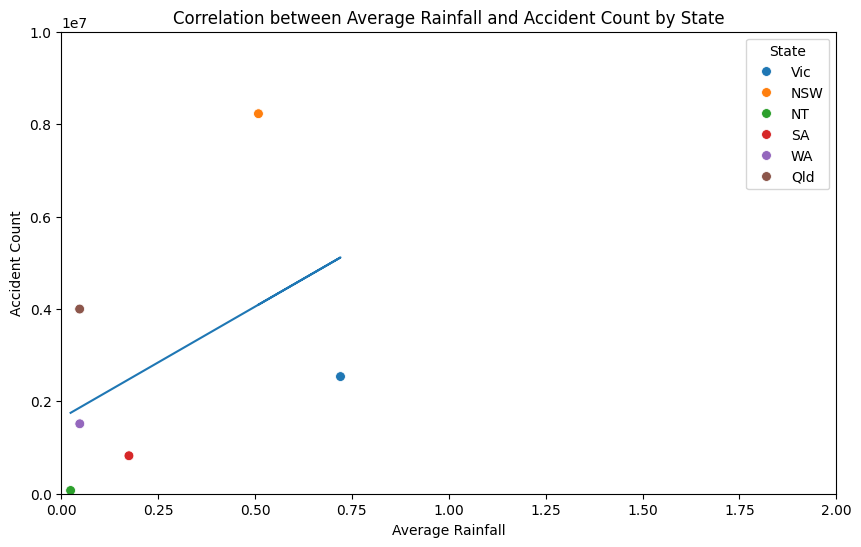

Correlation between Average Rainfall and Accident Count: 0.4760260304792914


In [149]:
# Correlation between weather (rainfall) and traffic accidents

mean_data_list = []

for state in unique_values:
    # Filter rows for the current State
    state_data = merged_df_state[merged_df_state['State'] == state]

    state_data['rainfall'] = pd.to_numeric(state_data['rainfall'], errors='coerce')
    
    # Calculate mean values for 'rainfall' and count of accidents
    mean_rainfall = state_data['rainfall'].mean()
    count_accident = (state_data['State'] == state).sum()
    
    mean_data_list.append({'State': state, 'mean_rainfall': mean_rainfall, 'count_accident': count_accident})

# Convert the list to a DataFrame for plotting
mean_data_df = pd.DataFrame(mean_data_list)

# Plotting
plt.figure(figsize=(10, 6))
m,b = np.polyfit(mean_data_df['mean_rainfall'], mean_data_df['count_accident'], 1)
plt.plot(x,m*x+b)
sns.scatterplot(x='mean_rainfall', y='count_accident', hue='State', data=mean_data_df, s=50)
plt.title('Correlation between Average Rainfall and Accident Count by State')
plt.xlabel('Average Rainfall')
plt.ylabel('Accident Count')
plt.legend(title='State')
plt.show()

# Drop any rows with NaN values that could have arisen from the mean calculation
mean_data_df.dropna(inplace=True)

# Calculate the Pearson correlation coefficient
correlation = mean_data_df['mean_rainfall'].corr(mean_data_df['count_accident'])

print(f"Correlation between Average Rainfall and Accident Count: {correlation}")

## 10. Correlation between income and traffic accidents and weather

  State  mean_rainfall  mean_accident   mean_income
0   NSW       0.508742       1.107807  58706.937500
1   VIC       0.720560       1.126761  54268.860759
2    SA       0.174622       1.056180  54108.602941
3    WA       0.047784       1.072727  66028.785185
4   QLD       0.047398       1.050926  51200.519481
5    NT       0.024089       1.000000  56325.687500


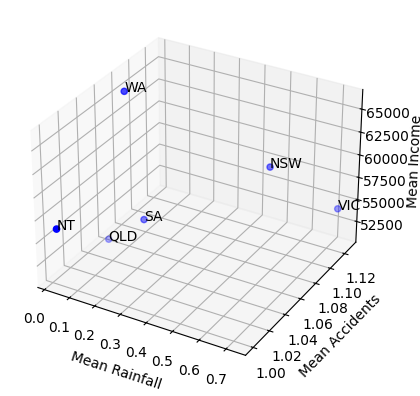

In [ ]:
# Getting mean_aud by state
vic_mean = income_df[income_to_merge['State'].str.upper() == 'VIC']['mean_aud'].mean()
nsw_mean = income_df[income_to_merge['State'].str.upper() == 'NSW']['mean_aud'].mean()
qld_mean = income_df[income_to_merge['State'].str.upper() == 'QLD']['mean_aud'].mean()
sa_mean = income_df[income_to_merge['State'].str.upper() == 'SA']['mean_aud'].mean()
wa_mean = income_df[income_to_merge['State'].str.upper() == 'WA']['mean_aud'].mean()
tas_mean = income_df[income_to_merge['State'].str.upper() == 'TAS']['mean_aud'].mean()
nt_mean = income_df[income_to_merge['State'].str.upper() == 'NT']['mean_aud'].mean()
# Finding the mean rainfall per state
mean_rainfall_state_list = []
weather_df['State'] = weather_df['State'].str.upper()
traffic_2023_df['State'] = traffic_2023_df['State'].str.upper()
merged_df_weather_TA_state = pd.merge(weather_df, traffic_2023_df, on='State')
unique_values = merged_df_weather_TA_state['State'].unique()

for state in unique_values:
    # Filter rows for the current State
    state_data = merged_df_weather_TA_state.loc[merged_df_weather_TA_state['State'] == state.upper()].copy()
    
    # Convert the columns to numeric
    state_data.loc[:, 'rainfall'] = pd.to_numeric(state_data['rainfall'], errors='coerce')
    state_data.loc[:, 'Number Fatalities'] = pd.to_numeric(state_data['Number Fatalities'], errors='coerce')
    
    # Calculate mean values for 'rainfall' and count of accidents
    mean_rainfall = state_data['rainfall'].mean()
    mean_accident = state_data['Number Fatalities'].mean()
    mean_rainfall_state_list.append({'State': state, 'mean_rainfall': mean_rainfall, 'mean_accident': mean_accident})
    
for rainfall in mean_rainfall_state_list:
    if rainfall['State'] == 'VIC':
        rainfall['mean_income'] = vic_mean
    elif rainfall['State'] == 'NSW':
        rainfall['mean_income'] = nsw_mean
    elif rainfall['State'] == 'SA':
        rainfall['mean_income'] = sa_mean
    elif rainfall['State'] == 'QLD':
        rainfall['mean_income'] = qld_mean
    elif rainfall['State'] == 'NT':
        rainfall['mean_income'] = nt_mean
    elif rainfall['State'] == 'WA':
        rainfall['mean_income'] = wa_mean
    elif rainfall['State'] == 'TAS':
        rainfall['mean_income'] = tas_mean

mean_df = pd.DataFrame(mean_rainfall_state_list)
print(mean_df)
#Exracting data to plot on graph
x = mean_df['mean_rainfall']
y = mean_df['mean_accident']
z = mean_df['mean_income']
states = mean_df['State']

fig = plt.figure()
viz = fig.add_subplot(111, projection='3d')

#3D scatter
scatter = viz.scatter(x, y, z, c='b', marker='o')
viz.set_xlabel('Mean Rainfall')
viz.set_ylabel('Mean Accidents')
viz.set_zlabel('Mean Income')

for i, state in enumerate(states):
    viz.text(x[i], y[i], z[i], state)

plt.show()